In [1]:
import numpy as np
import pandas as pd
import json
import csv
import seaborn as sns
import matplotlib.pyplot as plt

# Reading Data

In [2]:
# Reading a fixed version GNI88.csv (replaced one double quote with a single quote in line 369292) to a Pandas df
df = pd.read_csv("GNI88_fixed.csv")

In [3]:
df.head()

,artdate,Article ID,Headline,Quote ID,Article Status,Article Position,Messages,Submessages,Quote Position,Legacy Quote Tag,...,Source Religion,Legacy Source Tag,Constituent Group,Media Name,Media Medium,Journalist Name,Constituent Author,Article Issues,Custom Group,Media Group
0,2018-01-10,3759306,North Korea makes deals and threats,7023849,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Neutral,NaN,...,Unknown,Unknown,None (Legacy Other),Washington Post,NaN,"Fifield, Anna",NaN,NaN,NaN,NaN
1,2018-01-10,3759306,North Korea makes deals and threats,7023842,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Negative,NaN,...,Unknown,Unknown,None (Legacy Other),Washington Post,NaN,"Fifield, Anna",NaN,NaN,NaN,NaN
2,2018-01-10,3759306,North Korea makes deals and threats,7023839,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Negative,NaN,...,Unknown,Unknown,None (Legacy Other),Washington Post,NaN,"Fifield, Anna",NaN,NaN,NaN,NaN
3,2018-01-10,3759306,North Korea makes deals and threats,7023833,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Negative,NaN,...,Unknown,Unknown,None (Legacy Other),Washington Post,NaN,"Fifield, Anna",NaN,NaN,NaN,NaN
4,2018-01-10,3759306,North Korea makes deals and threats,7023846,News,Neutral,OLD Proliferation,OLD State Level Nuclear Programs,Positive,NaN,...,Unknown,Unknown,None (Legacy Other),Washington Post,NaN,"Fifield, Anna",NaN,NaN,NaN,NaN


# Data Cleaning and EDA

### Goal: Identify the Balance of Label Categories for Source Types

### Method: Find Value Counts and Value Proportions for 'Source Type'

Data Attributes for Reference

In [4]:
df.columns

Index(['artdate', 'Article ID', 'Headline', 'Quote ID', 'Article Status',
       'Article Position', 'Messages', 'Submessages', 'Quote Position',
       'Legacy Quote Tag', 'On/Off Message', 'QText', 'Source Name',
       'Source Type', 'Source Party Affiliation', 'Source Ethnicity',
       'Source Nationality', 'Source Gender', 'Source Religion',
       'Legacy Source Tag', 'Constituent Group', 'Media Name', 'Media Medium',
       'Journalist Name', 'Constituent Author', 'Article Issues',
       'Custom Group', 'Media Group'],
      dtype='object')

In [5]:
# helper function which will return a dataframe with values, counts, and their percent of representation in the data
def breakdown(col_name, df):
    """Inputs:
       - col_name: the name of the column to query a breakdown of
       - df: the dataframe to perform this analysis on
       Outputs:
       - a df with columns <col_name>, Count, and Percentage, where each row is a unique value of <col_name>"""
    tot = len(df)
    val_counts = df[col_name].value_counts()
    val_counts_df = pd.DataFrame(val_counts)
    val_counts_df = val_counts_df.reset_index()
    val_counts_df = val_counts_df.rename(columns={"index":col_name, col_name:"Count"})
    proportions = np.array(val_counts_df["Count"]) / tot
    val_counts_df["Percentage"] = proportions
    return val_counts_df

Breakdown for Category "Source Type"

In [6]:
# creating value_counts_proportions df for category "source type"
source_type_breakdown = breakdown("Source Type", df)

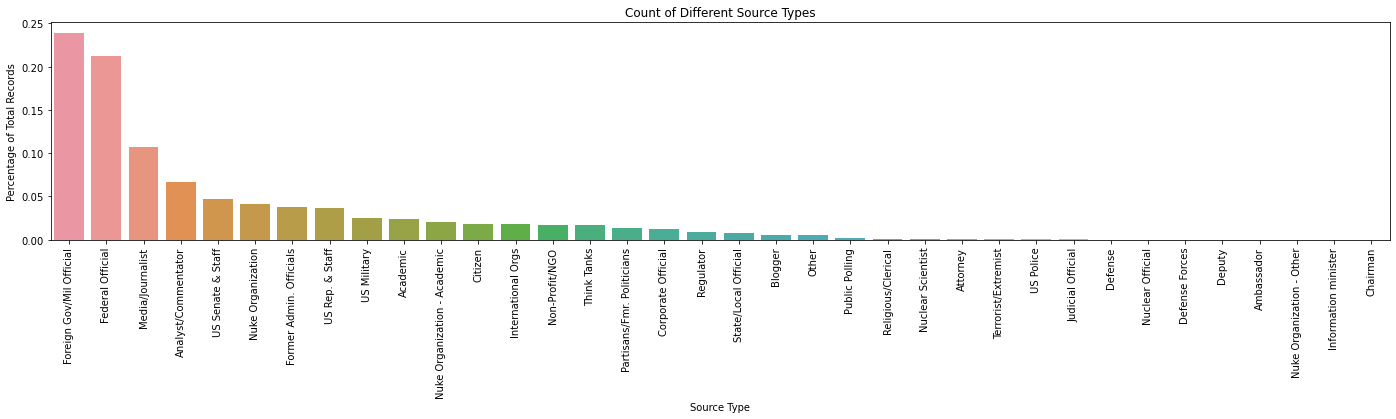

In [7]:
# plotting proportions of different source type categories.
plt.figure(figsize=[24,4]);
sns.barplot(x="Source Type",y="Percentage",data=source_type_breakdown);
plt.xticks(rotation="90",fontsize=10);
plt.ylabel("Percentage of Total Records");
plt.title("Count of Different Source Types");

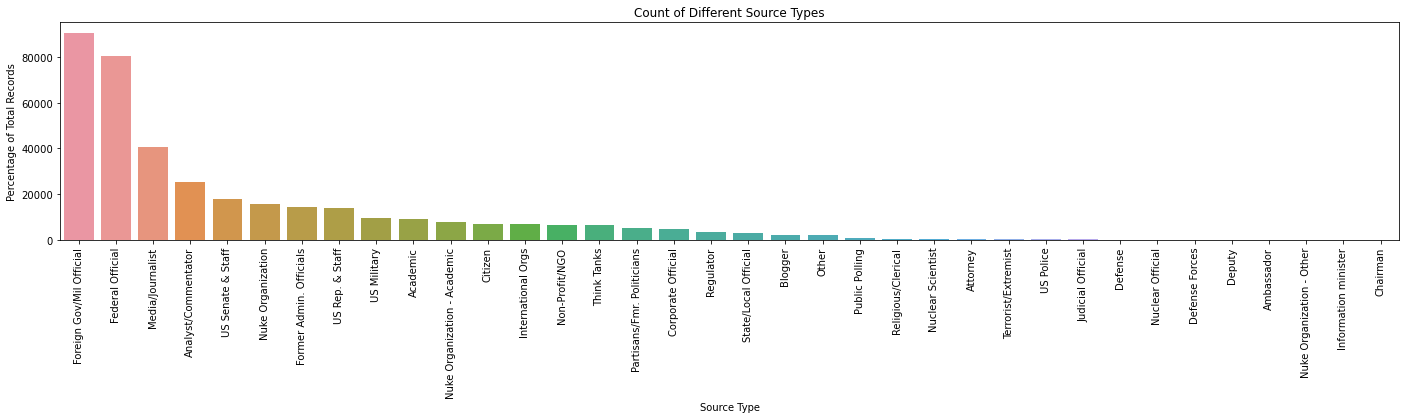

In [8]:
# plotting counts of different source type categories.
plt.figure(figsize=[24,4]);
sns.barplot(x="Source Type",y="Count",data=source_type_breakdown);
plt.xticks(rotation="90",fontsize=10);
plt.ylabel("Percentage of Total Records");
plt.title("Count of Different Source Types");

### Goal: Observe the Balance of Different Source Types Over Time

### Method: Line Plot of Source Type Proportions Over Time

#### First some preliminary data cleaning steps

In [9]:
# defining an array of each uniqe source type for reference
source_types = df["Source Type"].unique()

In [10]:
# creating a "year" column in our df so we have an integer column related to time

# defining a year extraction helper function
def extract_year(artdate):
    """Inputs:  
       - artdate, a string of format yyyy-mm-dd,
       Outputs: 
       - the year indicated by the artdate, as an integer"""
    year = int(artdate[:4])
    return year

# applying the year extraction function to create a "year" column in our df
years = df["artdate"].apply(extract_year)
df["year"] = years

In [11]:
# defining a helper function that takes a given source type and returns the behavior of its prevalence over time
def get_prop_over_time(source_type, df):
    """Inputs: 
       - source_type: string, the specific source type we wish to see the proportion of over time
       - df: dataframe to query the data from 
       Outputs:
       - an array of proportions in chronological order, one per year, where each item is the proportion of times
         where a quote was attributed to that source type that year"""
    years = np.sort(df["year"].unique())
    props = []
    for year in years:
    # find the proportion of times that source was the source of an quote in that year
        # filter df to get just that year
        just_year = df[df["year"]==year]
        # count how many quotes
        all_quotes = len(just_year)
        # count how many quotes were from the target source type
        target_quotes = len(just_year[just_year["Source Type"] == source_type])
        # divide that by total count
        prop = target_quotes / all_quotes
        # append that proportion to props
        props.append(prop)
    return props

#### Now creating the custom df to make this line plot from

In [12]:
# initializing a dataframe in which each column is a different source type and the index is year.
# each cell represents the proportion of quotes in that year which were attributed to that source type
df_by_source = pd.DataFrame()
df_by_source

""


In [13]:
# indexing the new dataframe by year
years = np.sort(df["year"].unique())
df_by_source["year"] = years

In [14]:
# filling the new dataframe column by column using the get_prop_over_time helper function
for source_type in source_types:
    df_by_source[source_type] = get_prop_over_time(source_type, df)

In [15]:
# final df modifications
df_by_source.set_index('year', drop=True)
df_by_source.head()

,year,Foreign Gov/Mil Official,Federal Official,US Military,Citizen,Media/Journalist,US Rep. & Staff,State/Local Official,US Senate & Staff,Analyst/Commentator,...,US Police,Terrorist/Extremist,Ambassador,Defense,Defense Forces,Information minister,Deputy,Nuke Organization - Other,Nuclear Official,Chairman
0,2011,0.230427,0.160502,0.013248,0.017996,0.126336,0.047513,0.001727,0.045455,0.063417,...,0.002357,0.000631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012,0.254269,0.161269,0.017543,0.016863,0.163503,0.031143,0.000797,0.052532,0.086570,...,0.000661,0.001690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013,0.255836,0.204336,0.016199,0.017255,0.151313,0.031607,0.001319,0.043949,0.073809,...,0.000000,0.000142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014,0.267033,0.232309,0.019746,0.015528,0.123766,0.026654,0.001070,0.060248,0.050527,...,0.000306,0.000245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,0.193362,0.244422,0.011119,0.016208,0.073057,0.071947,0.012156,0.125901,0.062082,...,0.000241,0.000844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Now finally plotting the line plots from the new df

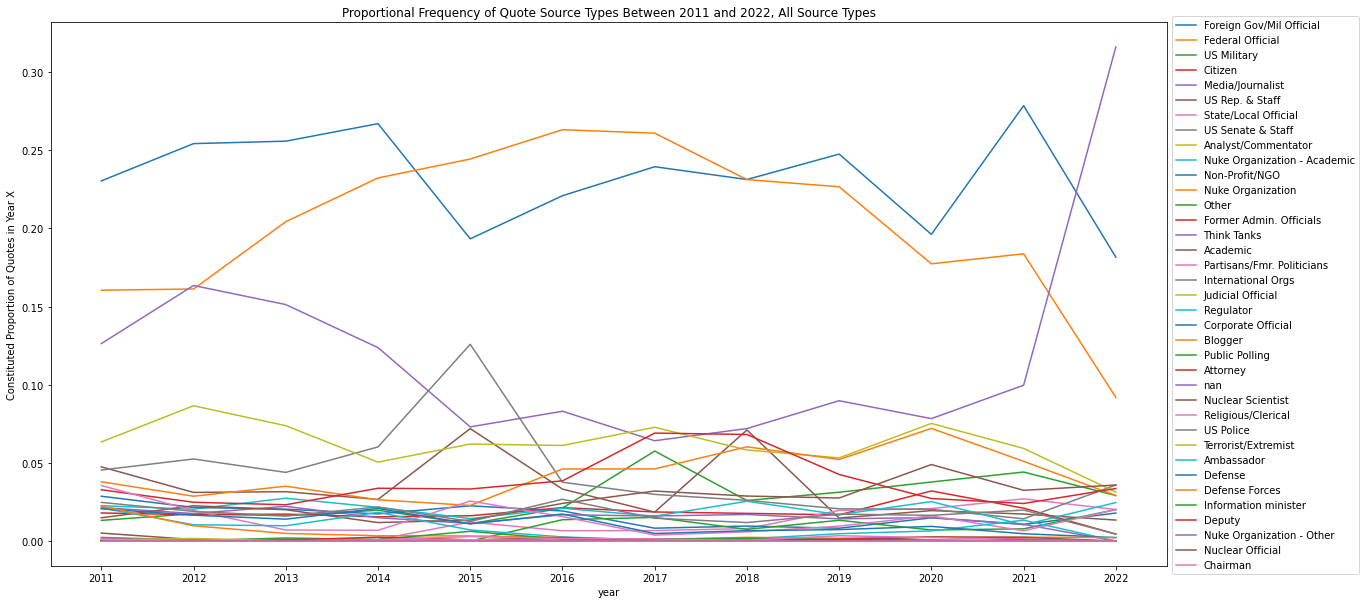

In [16]:
# using this new df to create a line plot to visualize the prevalence of difference source types over time
plt.figure(figsize=[20, 10]);
for source_type in source_types:
    sns.lineplot(x=df_by_source.index,y=source_type,data=df_by_source, label=source_type);
plt.legend(bbox_to_anchor=(1, 1.02));
plt.xticks(range(12),years);
plt.xlabel("year");
plt.ylabel("Constituted Proportion of Quotes in Year X");
plt.title("Proportional Frequency of Quote Source Types Between 2011 and 2022, All Source Types");

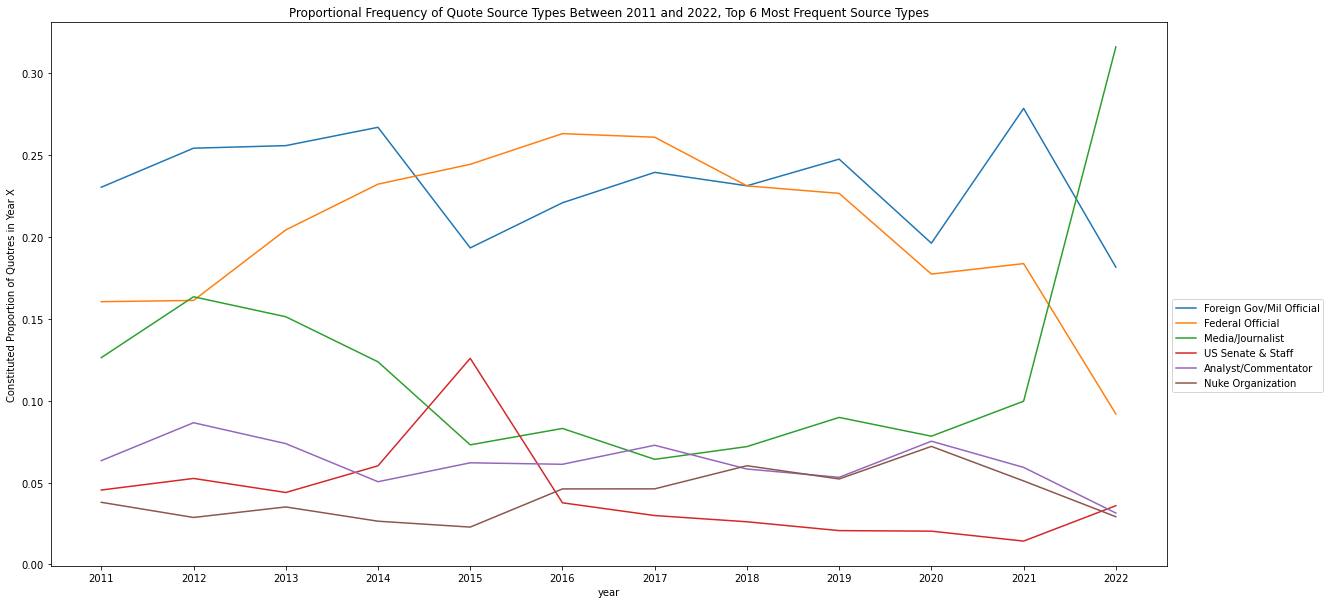

In [17]:
# the previous plot was messy, so let's only display source types for which there exist a nontrivial amount of records.
# we do this by seeing if the sum of source type proportions is 0.48, meaning that over the 12 years between 2011-2022
# the source type needs to have accounted for more than 0.04 of the total quotes that year on average.
# this thins out the plot to produce an intelligble result
plt.figure(figsize=[20, 10]);
for source_type in source_types:
    if sum(df_by_source[source_type]) >= 0.48:
        sns.lineplot(x=df_by_source.index,y=source_type,data=df_by_source, label=source_type);
plt.legend(bbox_to_anchor=(1, 0.5));
plt.xticks(range(12),years);
plt.xlabel("year");
plt.ylabel("Constituted Proportion of Quotres in Year X");
plt.title("Proportional Frequency of Quote Source Types Between 2011 and 2022, Top 6 Most Frequent Source Types");

### Conclusions:

With the exception of Media/Journalist making a dramatic surge in prevalence in 2022 (which may be due to less total quotes in 2022 and thus greater variability), most of the source types do not exhibit any drastic changes over time, meaning the total frequencies of source types are likely reliable as we decide which source types are really the most prevalent.

It is also worth noting that the majority of source types barely account for the quotes in the data and that only a handful of source types substantially account for these quotes instead. This could be helpful as it means many source types could be dropped, simplifying our decision process of which labels to utilize in a machine learning quote classification model.

### Old Work: Value Counts and Value Proportions for "Media Name," "Constituent Group," and "Media Group"

Breakdown for Category "Media Name"

\# creating value_counts_proportions df for category "media name"
media_name_breakdown = breakdown("Media Name")

\# plotting proportions of different media name categories. Only 70 largest are shown for neat plotting purposes
plt.figure(figsize=[24,4]);
sns.barplot(x="Media Name",y="Percentage",data=media_name_breakdown[:70]);
plt.xticks(rotation="90",fontsize=10);
plt.ylabel("Percentage of Total Records");
plt.title("Proportional Share of Different Media Name Categories, 70 Largest");

\# plotting counts of different media name categories.
plt.figure(figsize=[24,4]);
sns.barplot(x="Media Name",y="Count",data=media_name_breakdown[:70]);
plt.xticks(rotation="90",fontsize=10);
plt.ylabel("Count");
plt.title("Count of Different Media Name Categories, 70 Largest");

Breakdown for Category "Constituent Group"

\# creating value_counts_proportions df for category "constituent group"
constituent_breakdown = breakdown("Constituent Group")

\# plotting proportions of different constituent group categories. 
#'None (Legacy Other)' is excluded since it is an outlier which accounts for >80% of constituent groups
plt.figure(figsize=[24,4]);
sns.barplot(x="Constituent Group",y="Percentage",data=constituent_breakdown[1:]);
plt.xticks(rotation="90",fontsize=10);
plt.ylabel("Percentage of Total Records");
plt.title("Proportional Share of Different Constituent Group Categories, Excluding 'None (Legacy Other)'");

\# plotting counts of different constituent group categories.
plt.figure(figsize=[24,4]);
sns.barplot(x="Constituent Group",y="Count",data=constituent_breakdown[1:]);
plt.xticks(rotation="90",fontsize=10);
plt.ylabel("Count");
plt.title("Count of Different Constituent Group Categories, Excluding 'None (Legacy Other)'");

Breakdown for Category "Media Group"

\# creating value_counts_proportions df for category "media group"
media_group_breakdown = breakdown("Media Group")

\# plotting proportions of different media group categories. 
plt.figure(figsize=[10,6]);
sns.barplot(x="Media Group",y="Percentage",data=media_group_breakdown);
plt.xticks(fontsize=10);
plt.ylabel("Percentage of Total Records");
plt.title("Proportional Share of Different Media Group Categories, Excluding NAs");

\# plotting counts of different media group categories. 
plt.figure(figsize=[10,6]);
sns.barplot(x="Media Group",y="Count",data=media_group_breakdown);
plt.xticks(fontsize=10);
plt.ylabel("Count");
plt.title("Count of Different Media Group Categories, Excluding NAs");